In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    # Многомерное распределение Стьюдента
    nu = 4
    d = len(x)
    return -0.5 * (nu + d) * np.log(1 + np.dot(x, x) / nu)

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad = grad_logp(x)
        mean_prop = x + 0.5 * step**2 * grad
        prop = mean_prop + step * rng.normal(size=d)

        logp_x = logp(x)
        logp_prop = logp(prop)

        grad_prop = grad_logp(prop)
        mean_back = prop + 0.5 * step**2 * grad_prop

        log_q_forward = -0.5 * np.sum((prop - mean_prop)**2) / step**2
        log_q_backward = -0.5 * np.sum((x - mean_back)**2) / step**2

        log_alpha = (logp_prop + log_q_backward) - (logp_x + log_q_forward)
        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [15]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 1.1               # тут попробуйте подобрать хороший шаг
mh_scale = 2.4 / np.sqrt(d)      # тут попробуйте подобрать скейл для пропозала в MH. Может какие-то варианты будут лучше MALA?

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

# Выведите снизу acceptance rate и медианный ESS по размерности d для MH и MALA. Не забудьте обрезать burn-in!

mh_chain = mh_chain[burn:]
mala_chain = mala_chain[burn:]

mh_ess = np.median([ess(mh_chain[:, i]) for i in range(d)])
mala_ess = np.median([ess(mala_chain[:, i]) for i in range(d)])

print(f"MH acceptance rate: {mh_acc:.3f}")
print(f"MALA acceptance rate: {mala_acc:.3f}")
print(f"Median ESS (MH): {mh_ess:.1f}")
print(f"Median ESS (MALA): {mala_ess:.1f}")


MH acceptance rate: 0.261
MALA acceptance rate: 0.602
Median ESS (MH): 722.2
Median ESS (MALA): 7530.3


In [16]:
# Здесь нарисуйте 3 графика: trace plot (значение цепи vs итерация),
# график автокорреляции (значение ACF vs задержка по времени) и гистограмма семплов (возьмите какую-то одну размерность)

import matplotlib.pyplot as plt

dim = 0

def autocorr(x, max_lag=200):
    x = x - x.mean()
    result = np.correlate(x, x, mode='full')
    acf = result[result.size // 2:] / result[result.size // 2]
    return acf[:max_lag]

lags = 200
mh_acf = autocorr(mh_chain[:, dim], lags)
mala_acf = autocorr(mala_chain[:, dim], lags)


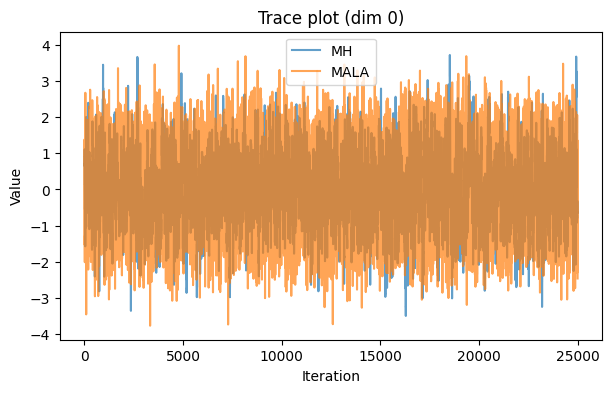

In [8]:
# Trace plot
plt.figure(figsize=(7, 4))
plt.plot(mh_chain[:, dim], label='MH', alpha=0.7)
plt.plot(mala_chain[:, dim], label='MALA', alpha=0.7)
plt.title(f"Trace plot (dim {dim})")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.show()

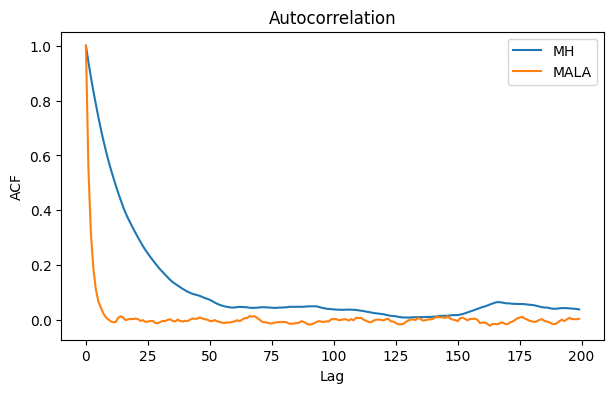

In [17]:
# Autocorrelation plot
plt.figure(figsize=(7, 4))
plt.plot(mh_acf, label='MH')
plt.plot(mala_acf, label='MALA')
plt.title("Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.legend()
plt.show()


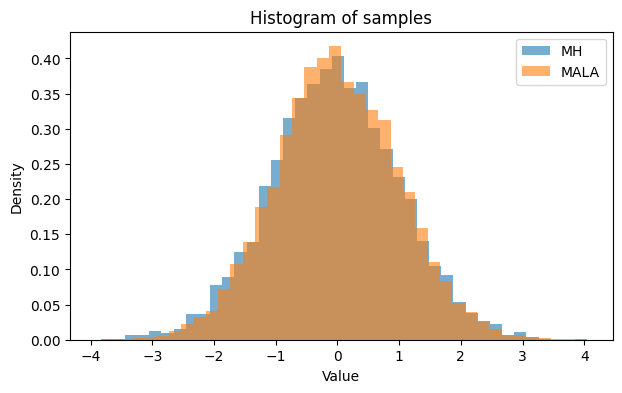

In [18]:
# Histogram
plt.figure(figsize=(7, 4))
plt.hist(mh_chain[:, dim], bins=40, alpha=0.6, density=True, label='MH')
plt.hist(mala_chain[:, dim], bins=40, alpha=0.6, density=True, label='MALA')
plt.title("Histogram of samples")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

**Вывод**: MALA эффективнее MH, так как она дала гораздо выше ESS, за счет использования градиента. При этом её acceptance rate показывает, что алгоритм движется без слишком частых отклонений.